In [1]:
#IMPORT NECESSARY PACKAGES
import CO2_functions
import CO2_Processing
import pandas as pd
from CO2_functions import *
from CO2_Processing import *
import matplotlib.pyplot as plt
import pickle
import numpy as np

In [231]:
import importlib
importlib.reload(CO2_functions)
importlib.reload(CO2_Processing)

from CO2_functions import *
from CO2_Processing import *

In [2]:
### Dump to Pickle
# with open('data.pickle', 'wb') as handle:
#     pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# Retrieve from Pickle
with open('data.pickle', 'rb') as handle:
    data = pickle.load(handle)

In [3]:
#data = full_download_process()
d = downsample_and_concatenate(data)

Concatenating Picarro Data
Concatenating Multi Data


In [4]:
def find_timesteps(df):
    from collections import Counter
    data = df.copy()
    if 'Corrected_DT' in data.columns:
        diff = data['Corrected_DT']-data['Corrected_DT'].shift(1)
    else:
        diff = data.reset_index()['Corrected_DT']-data.reset_index()['Corrected_DT'].shift(1)    
    c = Counter(diff)
    return c.most_common()[0][0].total_seconds()

def moving_average(df,time_window):
    data = df.copy()
    t_step = find_timesteps(data)
    roll_num = int(time_window//t_step)
    return data.rolling(roll_num,center=True).mean()

def dwn_sample(df,time_window):
    data = df.copy()
    return data.resample('{}S'.format(time_window)).mean() 

def pre_ds_filter(filter_func,dict_of_dfs):
    data = dict_of_dfs.copy()
    for key in data:
        if (filter_func == moving_average) | (filter_func == dwn_sample):
            time_window = float(input("Input the time window in seconds over which to conduct the filter function for {}".format(key)))
            data[key] = filter_func(data[key],time_window)
    return data

In [5]:
LI = {}
LI['LI'] = d['LI']

In [11]:
#roll = pre_ds_filter(moving_average,d)
#dwn = pre_ds_filter(dwn_sample,d)
roll_then_dwn_60_60 = pre_ds_filter(dwn_sample,pre_ds_filter(moving_average,LI))
roll_then_dwn_100_10 = pre_ds_filter(dwn_sample,pre_ds_filter(moving_average,LI))
roll_then_dwn_10_100 = pre_ds_filter(dwn_sample,pre_ds_filter(moving_average,LI))

Input the time window in seconds over which to conduct the filter function for LI 1000
Input the time window in seconds over which to conduct the filter function for LI 1000
Input the time window in seconds over which to conduct the filter function for LI 1000
Input the time window in seconds over which to conduct the filter function for LI 1000
Input the time window in seconds over which to conduct the filter function for LI 1000
Input the time window in seconds over which to conduct the filter function for LI 1000


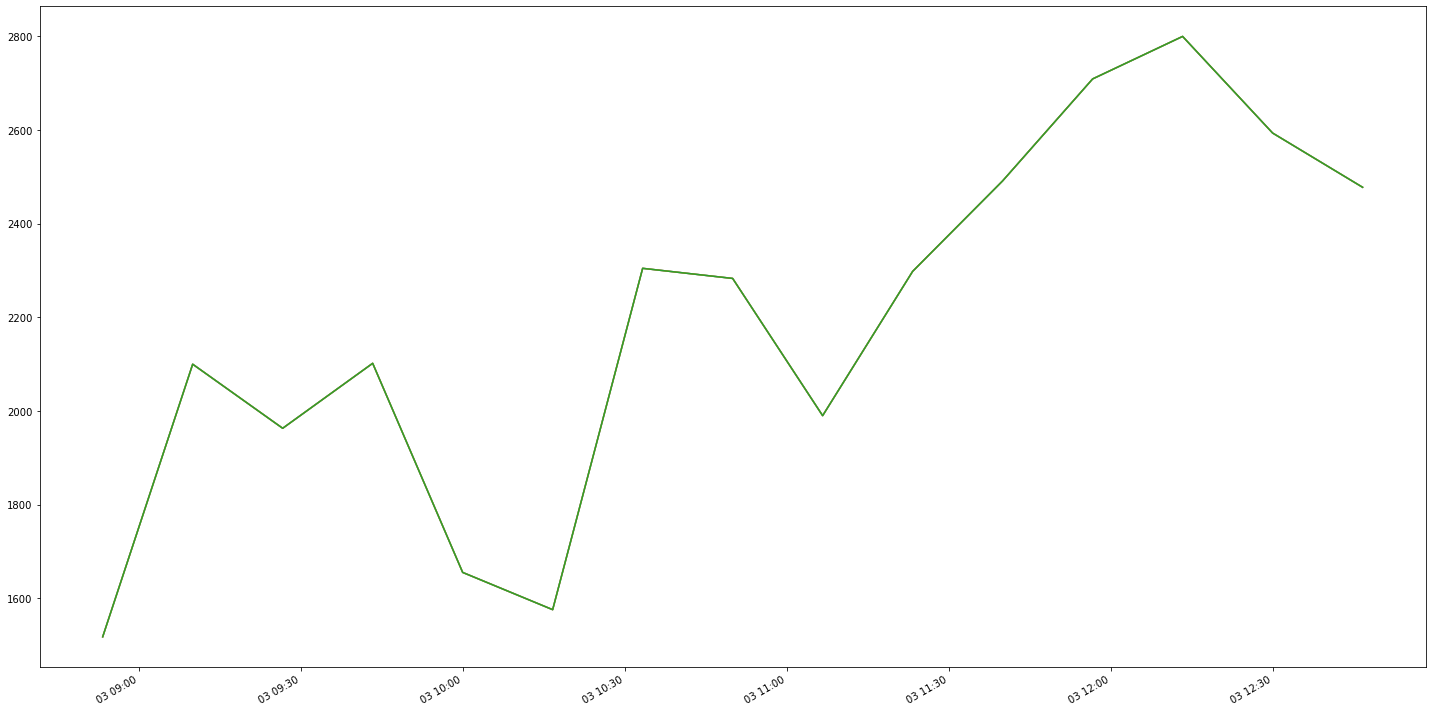

Is this an acceptable range?  y


[          Corrected_DT    EPOCH_TIME       LI_CO2  Corrected_ET
 0  2019-10-03 08:36:40           NaN          NaN           NaN
 1  2019-10-03 08:53:20  1.570116e+09  1517.761194  1.570115e+09
 2  2019-10-03 09:10:00  1.570117e+09  2099.722410  1.570116e+09
 3  2019-10-03 09:26:40  1.570118e+09  1962.915267  1.570117e+09
 4  2019-10-03 09:43:20  1.570119e+09  2101.618512  1.570118e+09
 5  2019-10-03 10:00:00  1.570120e+09  1655.232212  1.570119e+09
 6  2019-10-03 10:16:40  1.570121e+09  1575.700927  1.570120e+09
 7  2019-10-03 10:33:20  1.570122e+09  2304.373630  1.570121e+09
 8  2019-10-03 10:50:00  1.570123e+09  2282.810501  1.570122e+09
 9  2019-10-03 11:06:40  1.570124e+09  1989.842104  1.570123e+09
 10 2019-10-03 11:23:20  1.570125e+09  2297.857315  1.570124e+09
 11 2019-10-03 11:40:00  1.570126e+09  2491.044473  1.570125e+09
 12 2019-10-03 11:56:40  1.570127e+09  2708.704672  1.570126e+09
 13 2019-10-03 12:13:20  1.570128e+09  2799.451921  1.570127e+09
 14 2019-10-03 12:30:00  

In [12]:
plot_refinement_all([[roll_then_dwn_60_60['LI'],'Corrected_DT','LI_CO2'],[roll_then_dwn_10_100['LI'],'Corrected_DT','LI_CO2'],[roll_then_dwn_100_10['LI'],'Corrected_DT','LI_CO2']],'stack')

In [ ]:
data['Picarro']['roll_x'] = data['Picarro']['ANEM_X'].rolling(600,center=True).mean()
data['Picarro']['roll_y'] = data['Picarro']['ANEM_Y'].rolling(600,center=True).mean()
data['Picarro'] = wind_add(data['Picarro'],'ANEM_X','ANEM_Y')
pic = wind_add(data['Picarro'],'roll_x','roll_y')